## State Space models

Station Name: PHOENIX PARK
Station Height: 48 M 
Latitude:53.364  ,Longitude: -6.350


date:  -  Date and Time (utc)
rain:  -  Precipitation Amount (mm)	  
temp:  -  Air Temperature (C)	
wetb:  -  Wet Bulb Temperature (C)
dewpt: -  Dew Point Temperature (C)
vappr: -  Vapour Pressure (hPa)		                 
rhum:  -  Relative Humidity (%) 
msl:   -  Mean Sea Level Pressure (hPa)
ind:   -  Indicator


In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import cm
from jax.nn import one_hot
import jax.random as jr


In [2]:
df = pd.read_csv('irish_weather/hly175.csv')
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df.set_index('date', inplace=True)

def convert_float(col):
    parsed = []
    for i in range(len(df[col])):
        try:
            parsed.append(float(df.iloc[i][col]))
        except Exception as e:
            parsed.append(np.nan)
    return parsed

df['temp'] = convert_float('temp')
df['rain'] = convert_float('rain')
df['wetb'] = convert_float('wetb')

df.head()

/var/folders/__/ng_3_9pn1f11ftyml_qr69vh0000gn/T/ipykernel_79604/2027421057.py:1: DtypeWarning: Columns (2,4,6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('irish_weather/hly175.csv')


ind  rain  ind.1  temp  ind.2  wetb dewpt vappr rhum  \
date                                                                        
2003-08-16 01:00:00    0   0.0      0   9.2      0   8.9   8.5  11.1   95   
2003-08-16 02:00:00    0   0.0      0   9.0      0   8.7   8.5  11.1   96   
2003-08-16 03:00:00    0   0.0      0   8.2      0   8.0   7.7  10.5   96   
2003-08-16 04:00:00    0   0.0      0   8.4      0   8.1   7.9  10.7   97   
2003-08-16 05:00:00    0   0.0      0   7.7      0   7.5   7.3  10.2   97   

                        msl  year  
date                               
2003-08-16 01:00:00  1021.9  2003  
2003-08-16 02:00:00  1021.7  2003  
2003-08-16 03:00:00  1021.2  2003  
2003-08-16 04:00:00  1021.2  2003  
2003-08-16 05:00:00  1021.1  2003

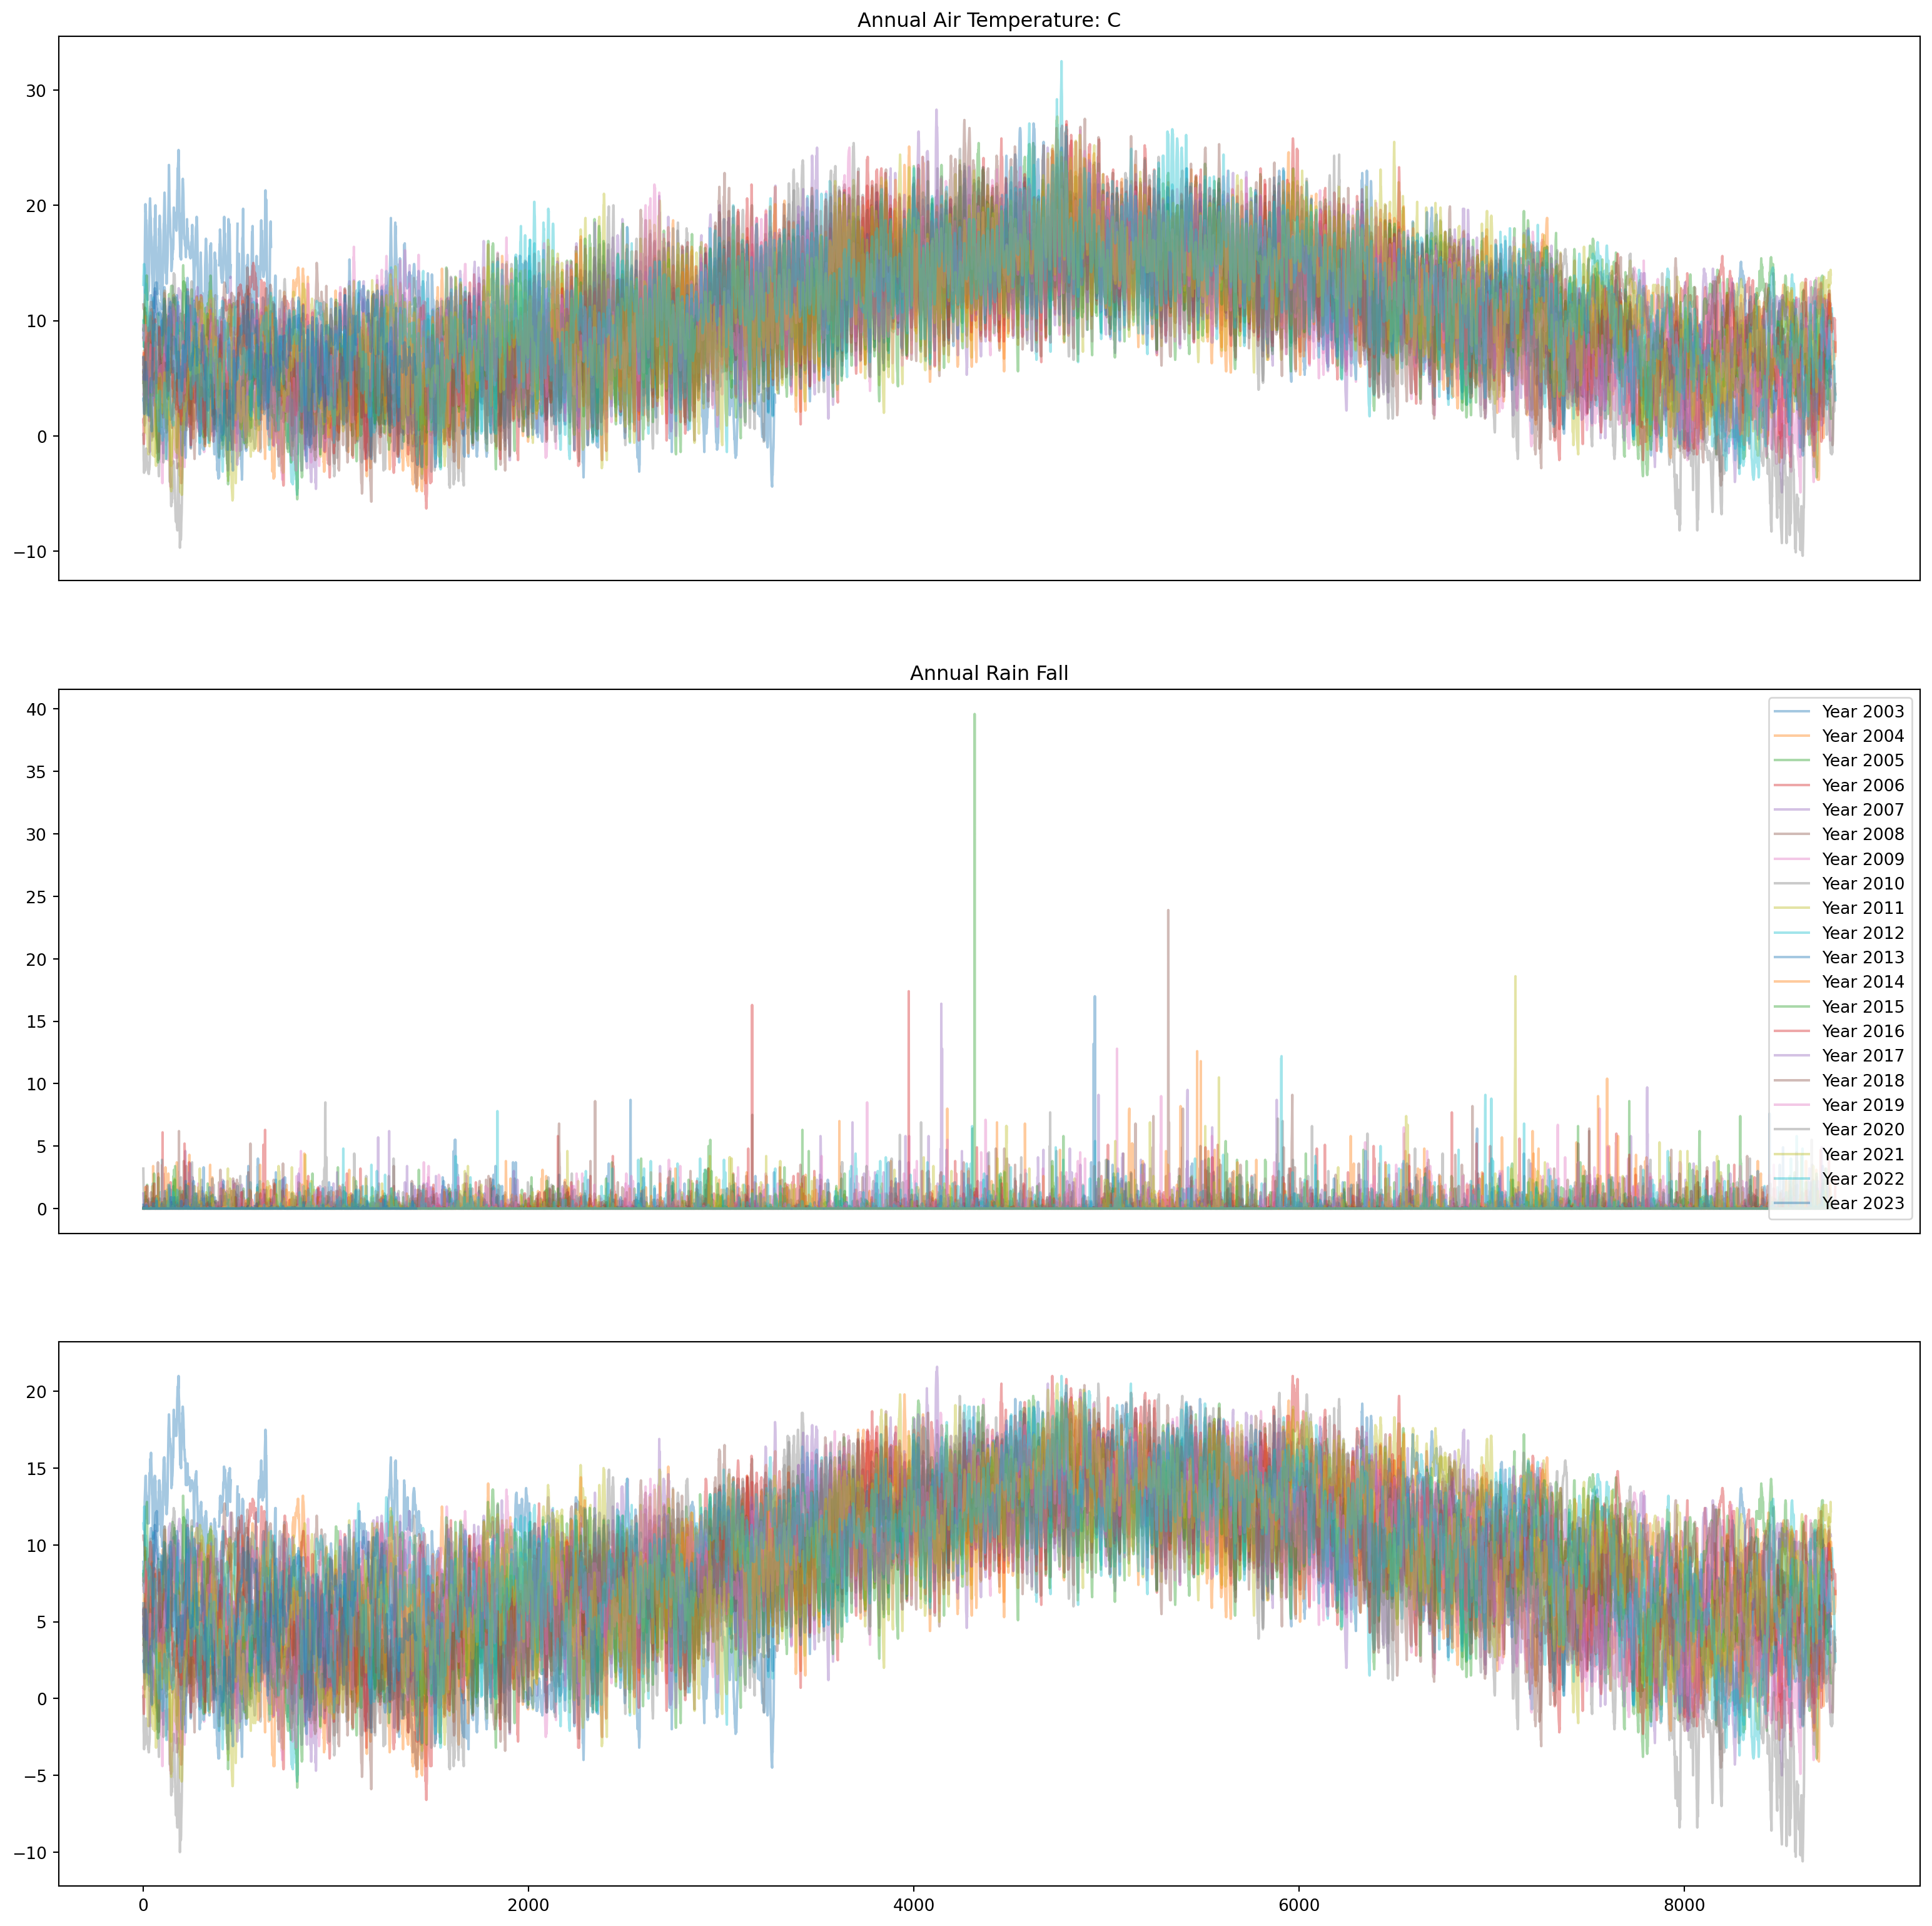

In [3]:
fig, axs = plt.subplots(3, 1, figsize=(20, 20))
axs = axs.flatten()
for y in df['year'].unique():
    temp = df[df['year'] == y].reset_index().sort_values('date')
    axs[0].plot(temp['temp'], label=f'Year {y}', alpha=0.4)
    axs[1].plot(temp['rain'], label=f'Year {y}', alpha=0.4)
    axs[2].plot(temp['wetb'], label=f'Year {y}', alpha=0.4)
axs[0].set_title("Annual Air Temperature: C")
axs[1].set_title("Annual Rain Fall")
axs[0].set_xticks([])
axs[1].set_xticks([])
axs[1].legend()

In [4]:
from jax import vmap

df_2020 = df[df['year'] == 2020]
emissions = df_2020["temp"].to_numpy()
emissions

emissions = np.atleast_2d(emissions).T
emissions


array([[6.8],
       [6.9],
       [6.2],
       ...,
       [4.4],
       [4.4],
       [4.5]])

In [5]:
from dynamax.hidden_markov_model import CategoricalHMM, GaussianHMM

true_num_states = 2
emission_dim = 1
key = jr.PRNGKey(0)

hmm = GaussianHMM(true_num_states, emission_dim)
params, props = hmm.initialize(key=key, method="kmeans", emissions=emissions)


/Users/nathanielforde/Documents/Github/NathanielF.github.io/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [6]:
params, lps = hmm.fit_em(params, props, emissions, num_iters=100)
params

ParamsGaussianHMM(initial=ParamsStandardHMMInitialState(probs=Array([0.916581  , 0.08341918], dtype=float32)), transitions=ParamsStandardHMMTransitions(transition_matrix=Array([[0.9762107 , 0.02378933],
       [0.02288962, 0.9771104 ]], dtype=float32)), emissions=ParamsGaussianHMMEmissions(means=Array([[ 6.289909 ],
       [14.2797365]], dtype=float32), covs=Array([[[7.8310475]],

       [[9.284886 ]]], dtype=float32)))

In [7]:
most_likely_states = hmm.most_likely_states(params, emissions)
most_likely_states

Array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

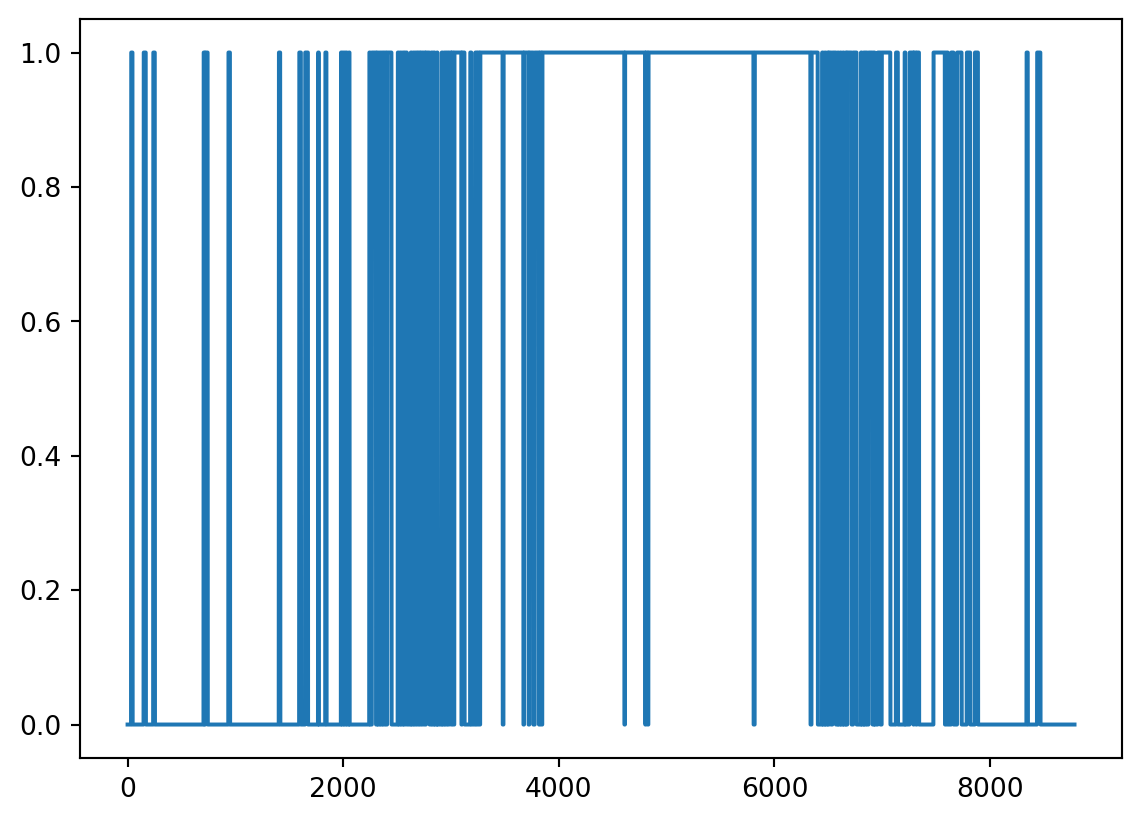

In [8]:
plt.plot(np.arange(most_likely_states.shape[0]), most_likely_states)

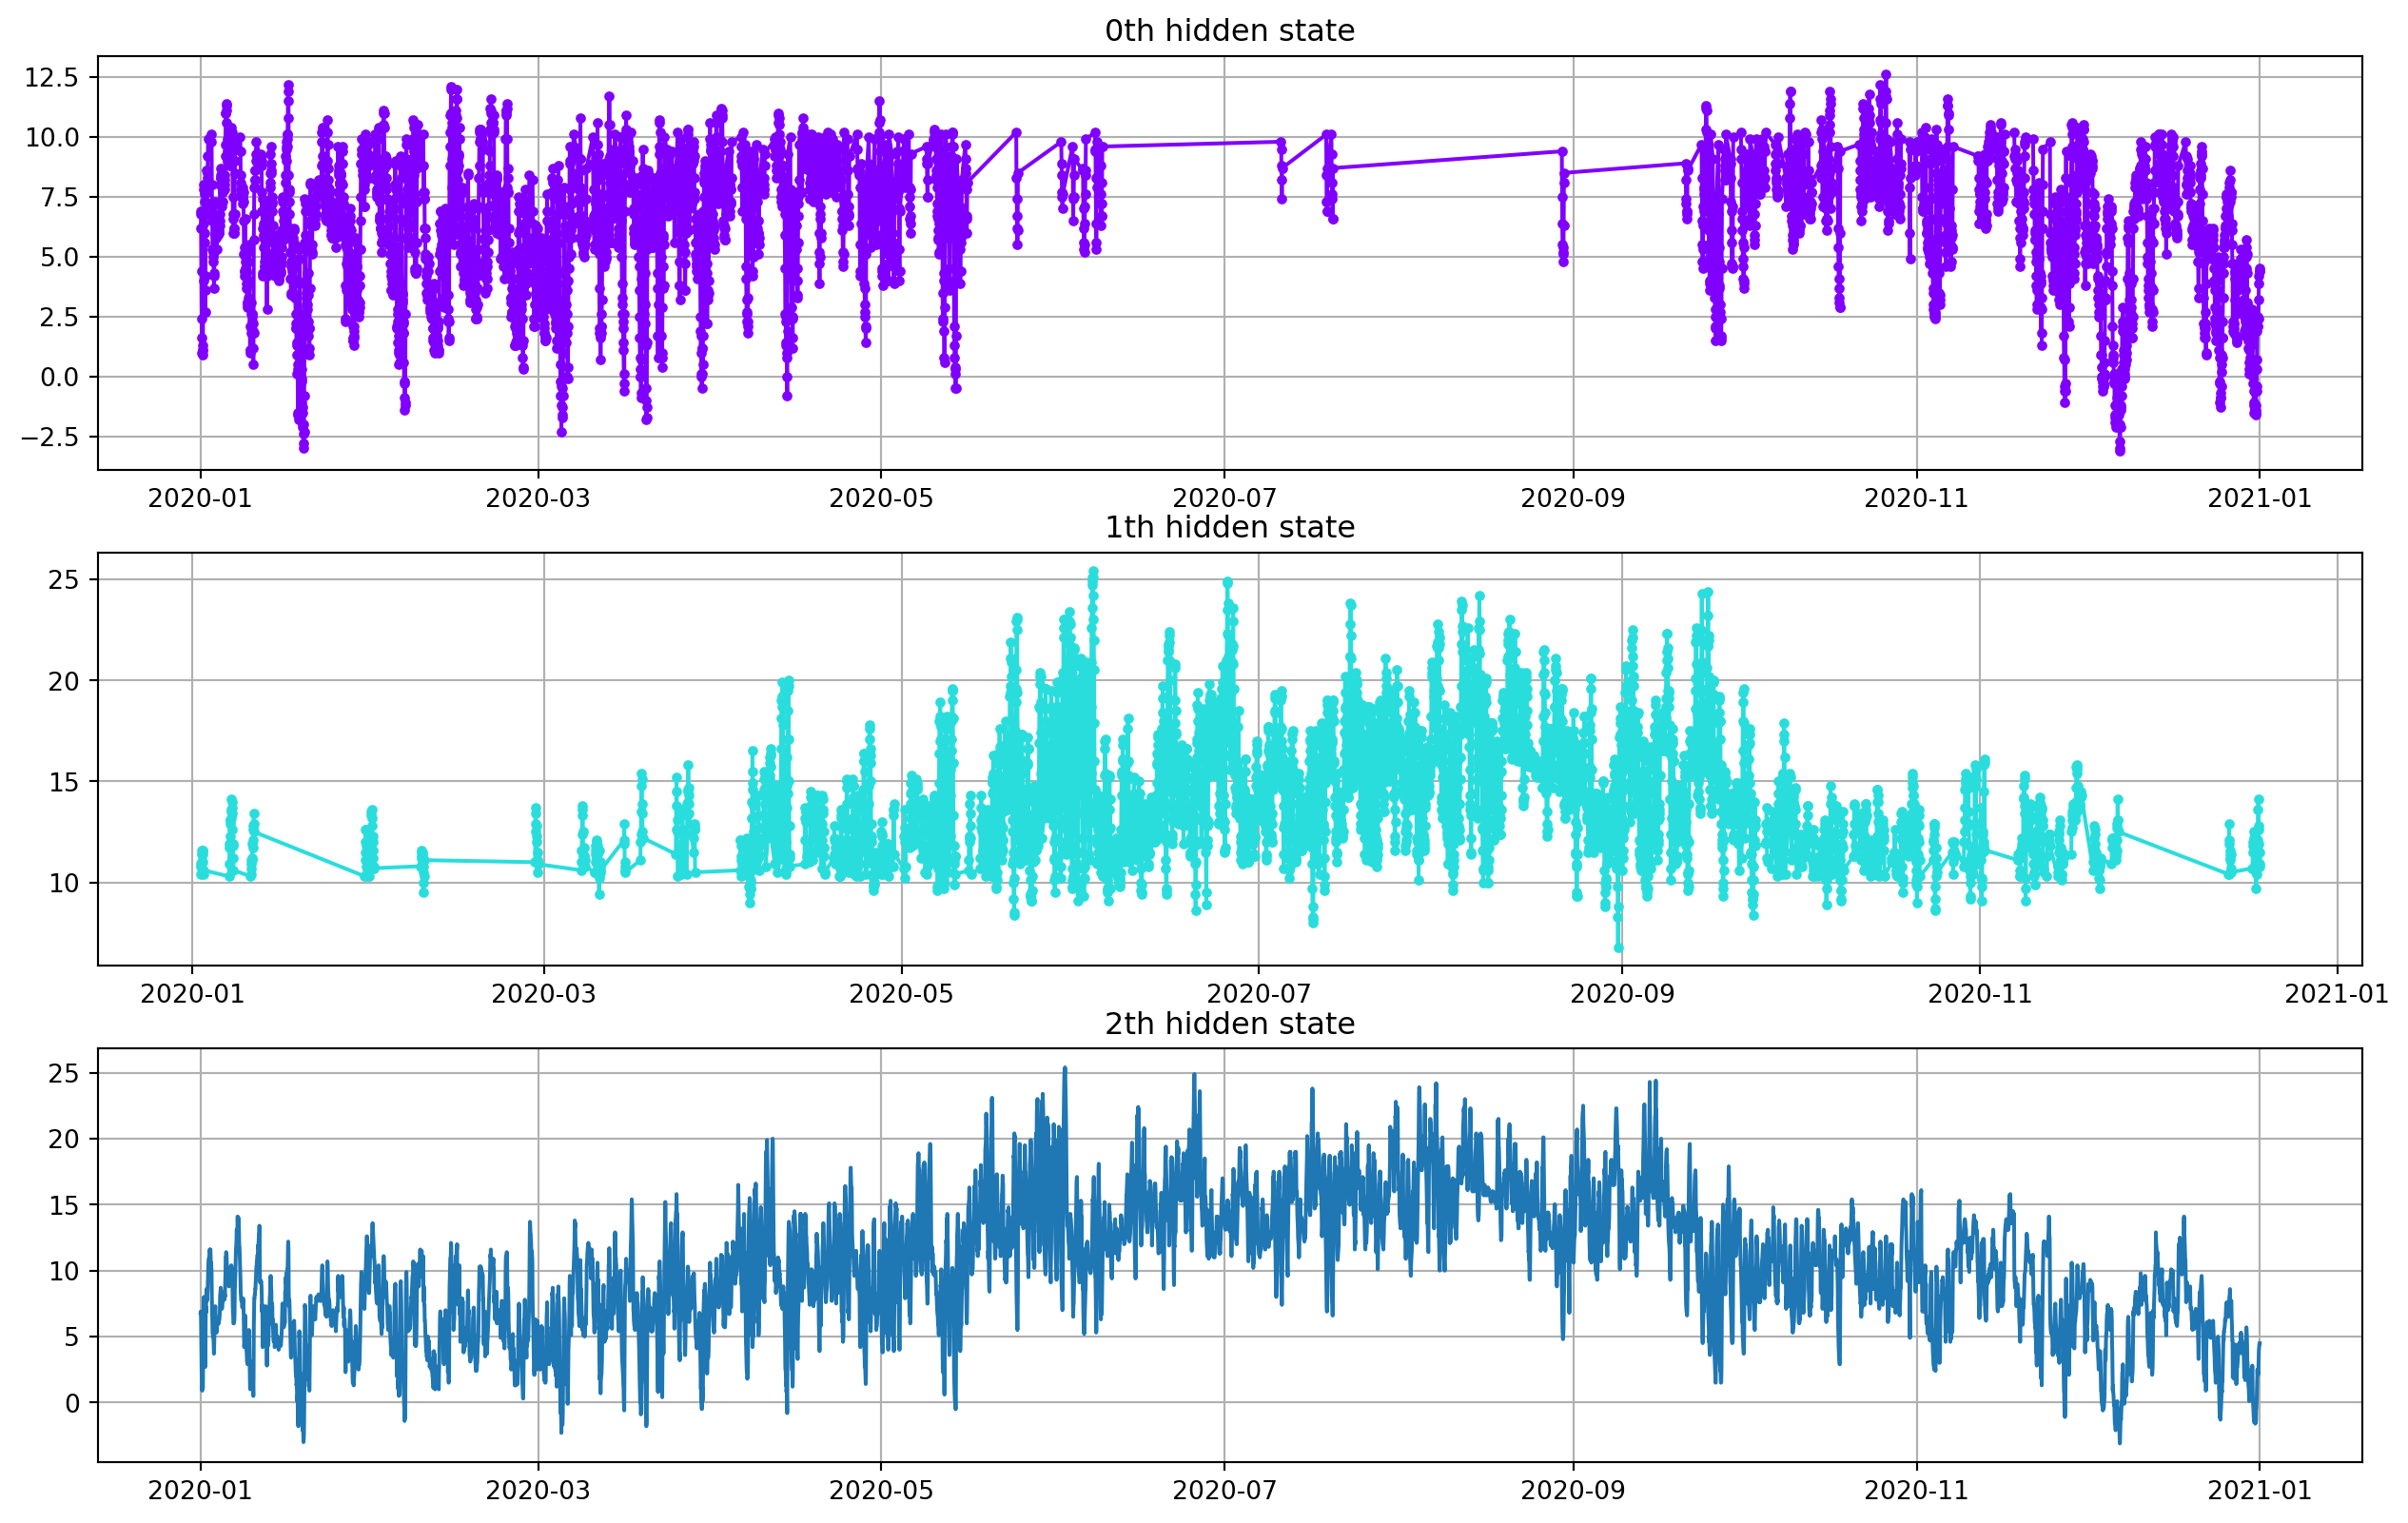

In [9]:
fig, axs = plt.subplots(3,1, figsize=(16,10))
colours = cm.rainbow(np.linspace(0, 1, 4))

for i, (ax, colour) in enumerate(zip(axs, colours)):
    # Use fancy indexing to plot data in each state.
    mask = most_likely_states == i
    #ax.plot(hist.reset_index()["Date"].iloc[mask], hist["Close"].iloc[mask], ".-", c=colour)
    ax.plot(df_2020.index[mask], df_2020["temp"].to_numpy()[mask],  ".-", c=colour)
    ax.set_title("{0}th hidden state".format(i))

    # Format the ticks.

    ax.grid(True)

axs[2].plot(df_2020['temp'])

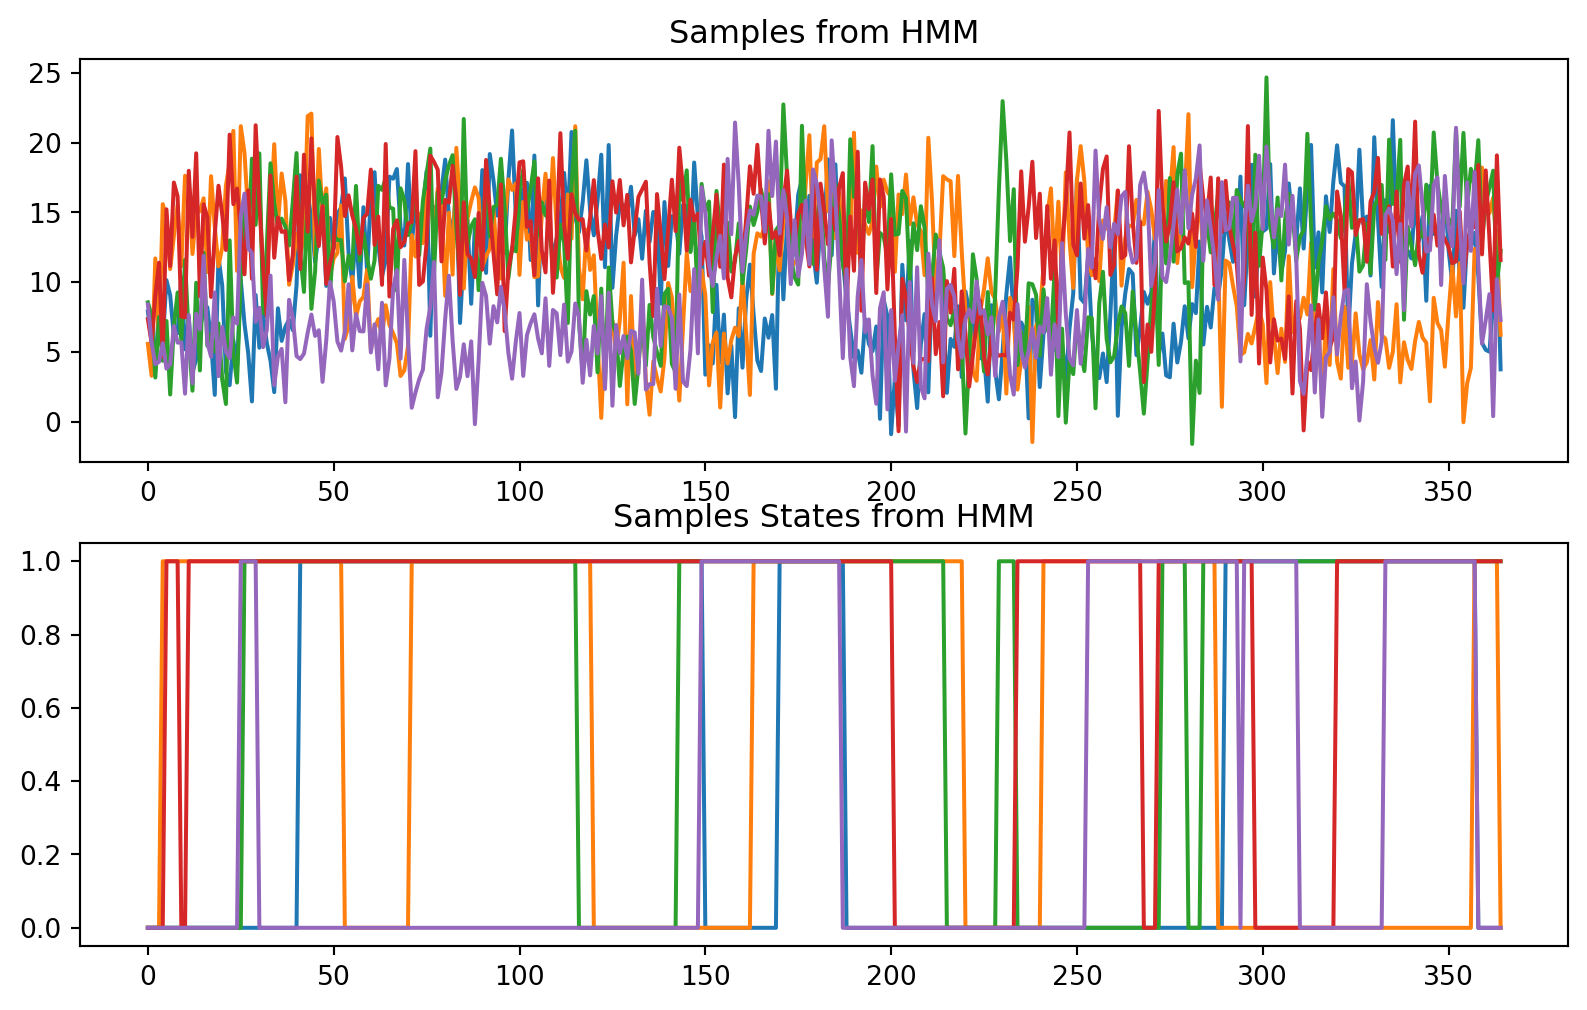

In [10]:
num_timesteps = 365

fig, axs = plt.subplots(2, 1, figsize=(10, 6))
axs = axs.flatten()
for i in range(5):
    true_states, emissions_samples = hmm.sample(params, jr.PRNGKey(i), num_timesteps)
    axs[0].plot(emissions_samples)
    axs[0].set_title("Samples from HMM")
    axs[1].set_title("Samples States from HMM")
    axs[1].plot(true_states)

In [11]:
posterior = hmm.filter(params, emissions)
print(f"marginal likelihood: {posterior.marginal_loglik: .2f}")
print(f"posterior.filtered_probs.shape: {posterior.filtered_probs.shape}")

marginal likelihood: -22534.17
posterior.filtered_probs.shape: (8784, 2)


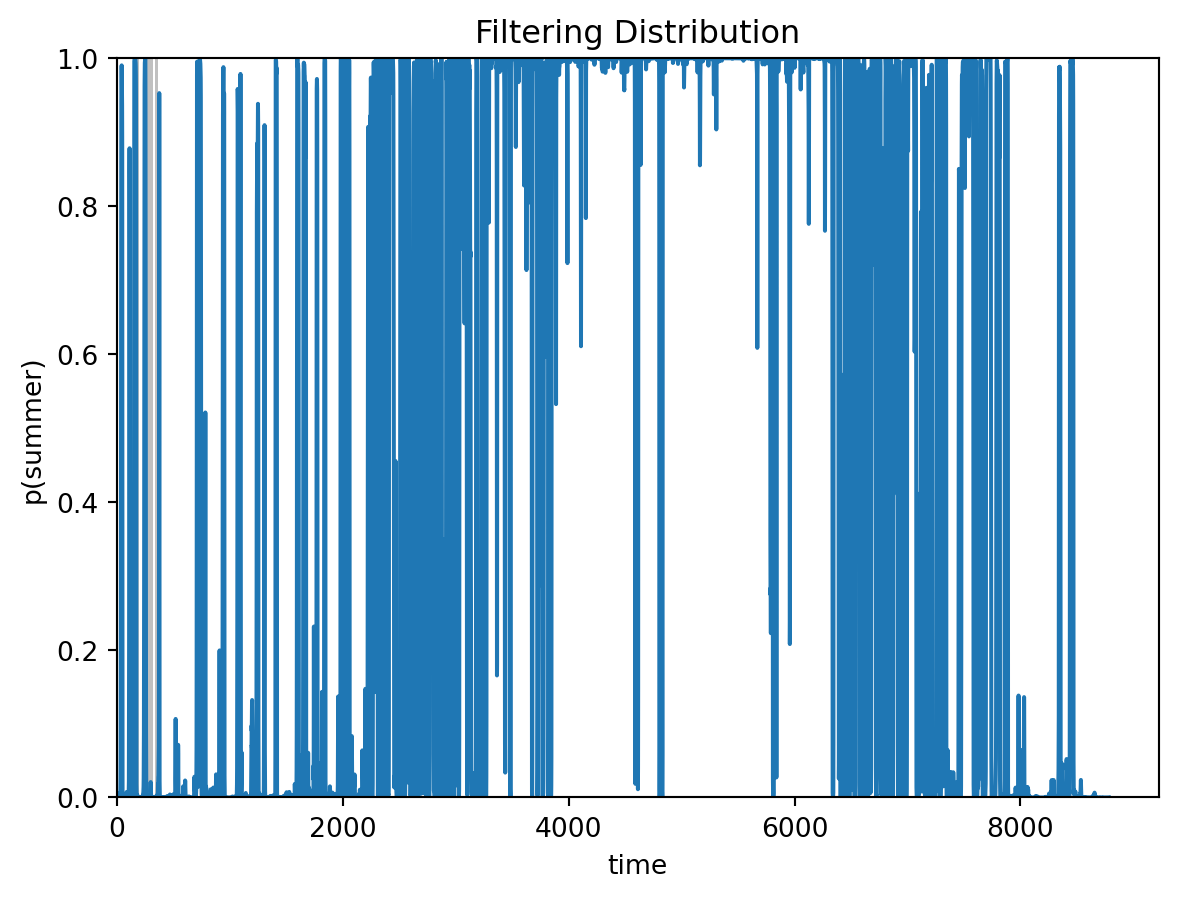

In [12]:
def plot_posterior_probs(probs, states, title=""):
    plt.imshow(states[None, :], extent=(0, num_timesteps, 0, 1), 
               interpolation="none", aspect="auto", cmap="Greys", alpha=0.25)
    plt.plot(probs[:, 1])   # probability of the loaded state (z=1)
    plt.xlabel("time")
    plt.ylabel("p(summer)")
    plt.ylim(0, 1)
    plt.title(title)

plot_posterior_probs(posterior.filtered_probs, true_states,
                     title="Filtering Distribution")

In [13]:
posterior_smooth = hmm.smoother(params, emissions)
print(f"posterior.smoothed_probs.shape: {posterior_smooth.smoothed_probs.shape}")


posterior.smoothed_probs.shape: (8784, 2)


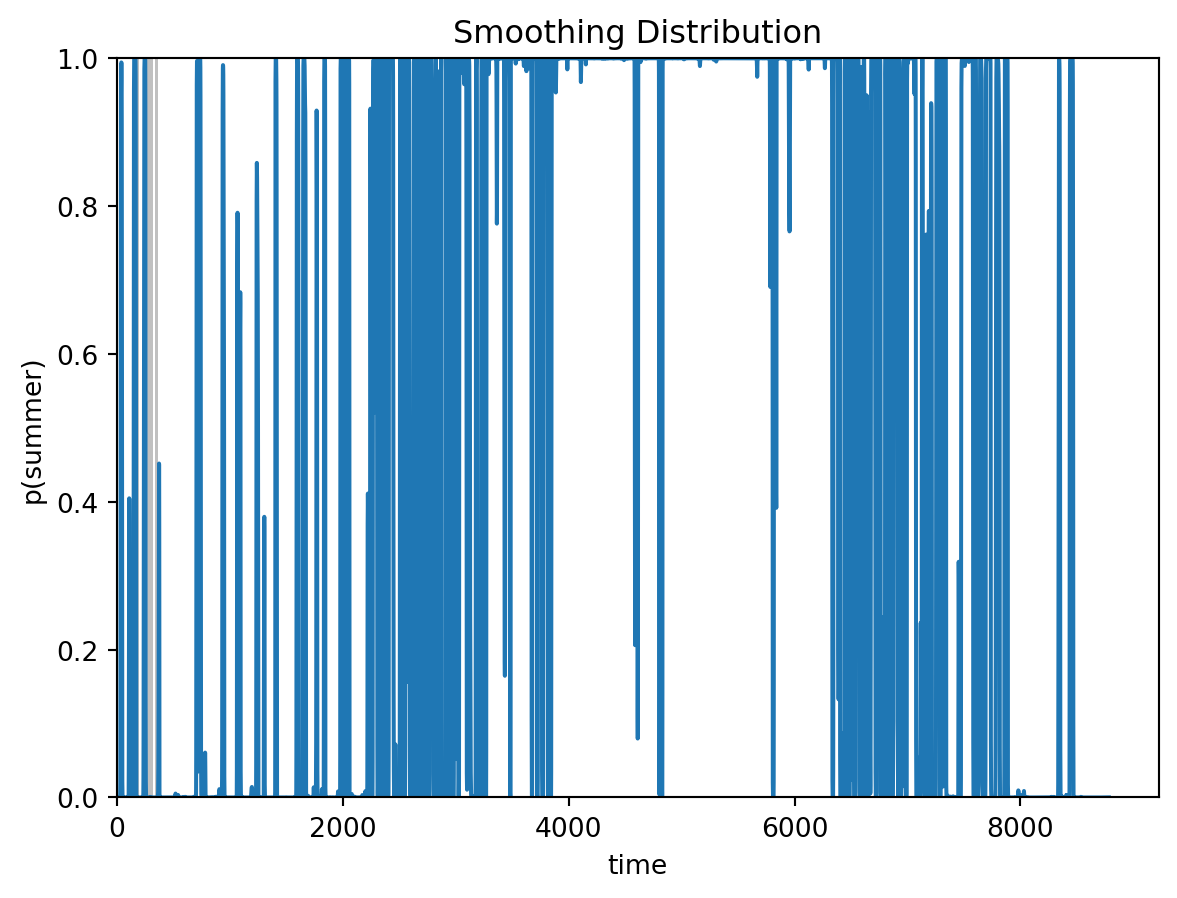

In [14]:
plot_posterior_probs(posterior_smooth.smoothed_probs, true_states,
                     title="Smoothing Distribution")
